In [1]:
import time
import os
import subprocess
import sys
sys.path.insert(0,'..')
import re
import argparse
import collections
import gzip
import math
import shutil
import matplotlib.pyplot as plt
import wandb
import numpy as np
import time
from datetime import datetime
import random

import seaborn as sns
%matplotlib inline
import logging
#silence_tensorflow()
os.environ['TPU_LOAD_LIBRARY']='0'
os.environ['TF_ENABLE_EAGER_CLIENT_STREAMING_ENQUEUE']='False'
import tensorflow as tf


import tensorflow.experimental.numpy as tnp
import tensorflow_addons as tfa
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision
from scipy.stats.stats import pearsonr  
from scipy.stats.stats import spearmanr  
## custom modules
#import src.aformer_atac as aformer
#import src.aformer_TF as aformer
#from src.layers.layers import *
#import src.metrics as metrics
#from src.optimizers import *
#import src.schedulers as schedulers
#import src.utils as utils

#import training_utils_atac as training_utils


from scipy import stats

2023-11-01 19:12:40.460371: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 19:12:40.538473: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-01 19:12:40.540354: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 19:12:42.335375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/conda/envs/3.8_env/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please

In [3]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='node-5',zone="us-central1-a")
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE
    options.deterministic=False
    #options.experimental_threading.max_intra_op_parallelism = 1
    mixed_precision.set_global_policy('mixed_bfloat16')
    tf.config.optimizer.set_jit(True)
    #options.num_devices = 64

    BATCH_SIZE_PER_REPLICA = 1
    NUM_REPLICAS = strategy.num_replicas_in_sync
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * NUM_REPLICAS

RuntimeError: TPU "node-5" is not yet ready; state: "STOPPED"

In [9]:

with strategy.scope():
    def one_hot(sequence):
        '''
        convert input string tensor to one hot encoded
        will replace all N character with 0 0 0 0
        '''
        vocabulary = tf.constant(['A', 'C', 'G', 'T'])
        mapping = tf.constant([0, 1, 2, 3])

        init = tf.lookup.KeyValueTensorInitializer(keys=vocabulary,
                                                   values=mapping)
        table = tf.lookup.StaticHashTable(init, default_value=0)

        input_characters = tfs.upper(tfs.unicode_split(sequence, 'UTF-8'))

        out = tf.one_hot(table.lookup(input_characters), 
                          depth = 4, 
                          dtype=tf.float32)
        return out

    


g = tf.random.Generator.from_seed(1)

with strategy.scope():
    list_files = tf.io.gfile.glob("gs://picard-testing-176520/genformer_atac_pretrain/262k/genformer_atac_pretrain_globalacc_conv_rpgc_test_holdout/peak_atlas/*.tfr")


    files = tf.data.Dataset.list_files(list_files)

    def deserialize_val(serialized_example,
                       input_length,
                       max_shift,
                       output_length_ATAC,
                       output_length,
                       crop_size,
                       output_res,
                       #seq_mask_dropout,
                       atac_mask_dropout,
                       mask_size,
                       log_atac,
                       use_atac,
                       use_seq,
                        g):
        """Deserialize bytes stored in TFRecordFile."""
        ## parse out feature map
        feature_map = {
            'sequence': tf.io.FixedLenFeature([], tf.string),
            'atac': tf.io.FixedLenFeature([], tf.string),
            'tss_tokens': tf.io.FixedLenFeature([], tf.string),
            'peaks': tf.io.FixedLenFeature([], tf.string)
        }
        ### stochastic sequence shift and gaussian noise

        seq_shift=5
        stupid_random_seed = g.uniform([], 0, 10000000,dtype=tf.int32)
        input_seq_length = input_length + max_shift

        ## now parse out the actual data
        data = tf.io.parse_example(serialized_example, feature_map)
        sequence = one_hot(tf.strings.substr(data['sequence'],
                                     seq_shift,input_length))
        atac = tf.ensure_shape(tf.io.parse_tensor(data['atac'],
                                                  out_type=tf.float32),
                               [output_length_ATAC,1])
        peaks = tf.ensure_shape(tf.io.parse_tensor(data['peaks'],
                                                  out_type=tf.int32),
                               [output_length])
        peaks = tf.expand_dims(peaks,axis=1)
        peaks_crop = tf.slice(peaks,
                         [crop_size,0],
                         [output_length-2*crop_size,-1])


        center = (output_length-2*crop_size)//2
        ### here set up masking of one of the peaks
        mask_indices_temp = tf.where(peaks_crop[:,0] > 0)[:,0]
        ridx = tf.concat([tf.constant([center],dtype=tf.int64)],axis=0)   ### concatenate the middle in case theres no peaks
        mask_indices=[[ridx[0]-2+crop_size],
                      [ridx[0]-1+crop_size],[ridx[0]+crop_size],[ridx[0]+1+crop_size],
                      [ridx[0]+2+crop_size],[ridx[0]+3+crop_size]]

        st=tf.SparseTensor(
            indices=mask_indices,
            values=[1.0]*len(mask_indices),
            dense_shape=[output_length])
        dense_peak_mask=tf.sparse.to_dense(st)
        dense_peak_mask_store = dense_peak_mask
        dense_peak_mask=1.0-dense_peak_mask
        dense_peak_mask = tf.expand_dims(dense_peak_mask,axis=1)

        atac_target = atac ## store the target

        ### here set up the ATAC masking
        num_mask_bins = mask_size // output_res
        out_length_cropped = output_length-2*crop_size
        edge_append = tf.ones((crop_size,1),dtype=tf.float32)
        atac_mask = tf.ones(out_length_cropped // num_mask_bins,dtype=tf.float32)
        atac_mask=tf.nn.experimental.stateless_dropout(atac_mask,
                                                  rate=(atac_mask_dropout),
                                                  seed=[stupid_random_seed+1,stupid_random_seed+2]) / (1. / (1.0-(atac_mask_dropout))) 
        atac_mask = tf.expand_dims(atac_mask,axis=1)
        atac_mask = tf.tile(atac_mask, [1,num_mask_bins])
        atac_mask = tf.reshape(atac_mask, [-1])
        atac_mask = tf.expand_dims(atac_mask,axis=1)
        atac_mask_store = 1.0 - atac_mask
        full_atac_mask = tf.concat([edge_append,atac_mask,edge_append],axis=0)
        full_comb_mask = dense_peak_mask#tf.math.floor((dense_peak_mask+full_atac_mask)/2)
        full_comb_mask_store = 1.0 - full_comb_mask
        full_comb_mask_store = full_comb_mask_store[crop_size:-crop_size,:]
        tiling_req = output_length_ATAC // output_length
        full_comb_mask = tf.expand_dims(tf.reshape(tf.tile(full_comb_mask, [1,tiling_req]),[-1]),axis=1)
        masked_atac = atac * full_comb_mask

        ### now that we have masked specific tokens by setting them to 0, we want to randomly add wrong tokens to these positions
        ## first, invert the mask
        random_shuffled_tokens= tf.random.experimental.stateless_shuffle(atac,seed=[10,stupid_random_seed+10])
        masked_atac = masked_atac + (1.0-full_comb_mask)*random_shuffled_tokens

        if log_atac: 
            masked_atac = tf.math.log1p(masked_atac)

        diff = tf.math.sqrt(tf.nn.relu(masked_atac - 100.0 * tf.ones(masked_atac.shape)))
        masked_atac = tf.clip_by_value(masked_atac, clip_value_min=0.0, clip_value_max=100.0) + diff

        atac_out = tf.reduce_sum(tf.reshape(atac_target, [-1,tiling_req]),axis=1,keepdims=True)
        diff = tf.math.sqrt(tf.nn.relu(atac_out - 2500.0 * tf.ones(atac_out.shape)))
        atac_out = tf.clip_by_value(atac_out, clip_value_min=0.0, clip_value_max=2500.0) + diff
        atac_out = tf.slice(atac_out,
                            [crop_size,0],
                            [output_length-2*crop_size,-1])

        peaks_gathered = tf.reduce_max(tf.reshape(peaks_crop, [(output_length-2*crop_size) // 2, -1]),
                                       axis=1,keepdims=True)
        mask_gathered = tf.reduce_max(tf.reshape(full_comb_mask_store, [(output_length-2*crop_size) // 2, -1]),
                                       axis=1,keepdims=True)

        random_shuffled_tokens= tf.random.experimental.stateless_shuffle(atac,
                                                                         seed=[11,stupid_random_seed+11])
        if not use_atac:
            masked_atac = random_shuffled_tokens
        if not use_seq:
            sequence = tf.random.experimental.stateless_shuffle(sequence,
                                                                seed=[1,stupid_random_seed+12])


        return {'sequence': tf.ensure_shape(sequence,
                                            [input_length,4]),
                'atac': tf.ensure_shape(masked_atac,
                                        [output_length_ATAC,1]),
                'atac_orig': tf.ensure_shape(atac,
                                        [output_length_ATAC,1]),
                'mask': tf.ensure_shape(full_comb_mask_store,
                                        [output_length-crop_size*2,1]),
                'full_comb_mask': tf.ensure_shape(full_comb_mask,
                                        [output_length_ATAC,1]),
                'mask_gathered': tf.ensure_shape(mask_gathered,
                                        [(output_length-crop_size*2)//2,1]),
                'peaks': tf.ensure_shape(peaks_gathered,
                                          [(output_length-2*crop_size) // 2,1]),
                'target': tf.ensure_shape(atac_out,
                                          [output_length-crop_size*2,1])}


    files = tf.data.Dataset.list_files(list_files)

    dataset = tf.data.TFRecordDataset(files,
                                      compression_type='ZLIB',
                                      num_parallel_reads=4)
    dataset = dataset.with_options(options)
    dataset = dataset.map(lambda record: deserialize_val(record,
                                                        262144,
                                                        10,
                                                        65536,
                                                        2048,
                                                        256,
                                                        128,
                                                         #seq_mask_dropout,
                                                        0.05,
                                                        512,
                                                        True,
                                                       True,
                                                       True,
                                                        g),
                  deterministic=False,
                  num_parallel_calls=4)

    dataset = dataset.batch(64,drop_remainder=True).prefetch(tf.data.AUTOTUNE).repeat(1)

    test_dist = strategy.experimental_distribute_dataset(dataset)

    test_it = iter(test_dist)
    test_it_build = iter(test_dist)

In [10]:
#with strategy.scope():
with strategy.scope():
    model = aformer.aformer(kernel_transformation='relu_kernel_transformation',
                            dropout_rate=0.30,
                            pointwise_dropout_rate=0.10,
                            input_length=262144,
                            output_length=2048,
                            final_output_length=1536,
                            num_heads=8,
                            numerical_stabilizer=0.0000001,
                            nb_random_features=256,
                            max_seq_length=2048,
                            rel_pos_bins=2048,
                            norm=True,
                            normalize = True,
                            BN_momentum=0.90,
                            use_rot_emb = True,
                            use_mask_pos = False,
                            num_transformer_layers=6,
                            load_init=False,
                            stable_variant=False,
                            freeze_conv_layers=False,
                            filter_list_seq=[768,896,1024,1152,1280,1536],
                            filter_list_atac=[32,64],
                            final_point_scale=4,
                            output_heads=["human"],
                            learnable_PE=True)


    def build_step(iterator): #input_batch, model, optimizer, organism, gradient_clip):
        @tf.function(jit_compile=True)
        def test_step(inputs):
            sequence=tf.cast(inputs['sequence'],dtype=tf.bfloat16)
            atac=tf.cast(inputs['atac'],dtype=tf.bfloat16)
            target=tf.cast(inputs['target'],dtype=tf.float32)
            #global_acc=tf.cast(inputs['global_acc'],dtype=tf.bfloat16)         
            input_tuple = sequence,atac#,global_acc

            output = model(input_tuple,
                           training=False)

        for _ in tf.range(1): ## for loop within @tf.fuction for improved TPU performance
            strategy.run(test_step, args=(next(iterator),))
            
            
build_step(test_it_build)
print('ran test input')
#model.load_weights("gs://picard-testing-176520/genformer_atac_pretrain/models/aformer_hg_262k_load-True_LR-0.01_T-7_D-0.3_2023-04-13_15:39:43/final/saved_model")
model.load_weights("gs://picard-testing-176520/genformer_atac_pretrain/models/aformer_hg_262k_load-True_LR-0.01_T-6_D-0.3_2023-04-26_00:40:44/iteration_84/saved_model")
print('loaded weights')


/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


ran test input
loaded weights


In [11]:
with strategy.scope():
    metric_dict = {}
    metric_dict["corr_stats_atac"] = metrics.correlation_stats_gene_centered(name='corr_stats')
    metric_dict["corr_stats_peaks"] = metrics.correlation_stats_gene_centered(name='corr_stats')
    def dist_test_step(iterator):
        @tf.function(jit_compile=True)
        def test_step(inputs):
            sequence=tf.cast(inputs['sequence'],dtype=tf.bfloat16)
            target=tf.cast(inputs['target'],dtype=tf.float32)
            atac=tf.cast(inputs['atac'],dtype=tf.bfloat16)
            mask=tf.cast(inputs['mask'],dtype=tf.int32)
            mask_gathered=tf.cast(inputs['mask_gathered'],dtype=tf.int32)
            peaks=tf.cast(inputs['peaks'],dtype=tf.float32)
            
            input_tuple = sequence,atac#,global_acc

            output_profile,output_peaks = model(input_tuple,
                                                training=False)
            output_profile = tf.cast(output_profile['human'],dtype=tf.float32) # ensure cast to float32
            output_peaks = tf.cast(output_peaks['human'],dtype=tf.float32)
            
            mask_indices = tf.where(mask[0,:,0] == 1)[:,0]
            
            target_atac = tf.gather(target[:,:,0], mask_indices,axis=1)
            output_atac = tf.gather(output_profile[:,:,0], mask_indices,axis=1)
            
            
            mask_gather_indices = tf.where(mask_gathered[0,:,0] == 1)[:,0]
            target_peaks = tf.gather(peaks[:,:,0], mask_gather_indices,axis=1)
            output_peaks = tf.gather(output_peaks[:,:,0], mask_gather_indices,axis=1)

            #dummy_var = tf.ones(target_atac.shape,dtype=tf.int32)
            
            return target_atac, output_atac, target_peaks, output_peaks#,dummy_var
            
        
        ta_pred_atac = tf.TensorArray(tf.float32, size=0, dynamic_size=True,clear_after_read=False) # tensor array to store preds
        ta_true_atac = tf.TensorArray(tf.float32, size=0, dynamic_size=True,clear_after_read=False) # tensor array to store vals
        ta_pred_peaks = tf.TensorArray(tf.float32, size=0, dynamic_size=True,clear_after_read=False) # tensor array to store preds
        ta_true_peaks = tf.TensorArray(tf.float32, size=0, dynamic_size=True,clear_after_read=False)  
        ta_dummy_pk = tf.TensorArray(tf.int32, size=0, dynamic_size=True,clear_after_read=False) 
        ta_dummy_atac = tf.TensorArray(tf.int32, size=0, dynamic_size=True,clear_after_read=False) 
            
        for _ in tf.range(1018): ## for loop within @tf.fuction for improved TPU performance
            pred_atac_rep,true_atac_rep, pred_peaks_rep,true_peaks_rep = \
                strategy.run(test_step,
                             args=(next(iterator),))
            
            #print(pred_atac_rep)
            
            pred_atac_reshape = tf.reshape(strategy.gather(pred_atac_rep, axis=1), [-1]) # reshape to 1D
            true_atac_reshape = tf.reshape(strategy.gather(true_atac_rep, axis=1), [-1])
            pred_peaks_reshape = tf.reshape(strategy.gather(pred_peaks_rep, axis=1), [-1]) # reshape to 1D
            true_peaks_reshape = tf.reshape(strategy.gather(true_peaks_rep, axis=1), [-1])
            
            dummy_reshape_pk = tf.ones(true_peaks_reshape.shape,dtype=tf.int32)#tf.reshape(strategy.gather(dummy_int, axis=0), [-1])
            dummy_reshape_atac = tf.ones(true_peaks_reshape.shape,dtype=tf.int32)

            ta_pred_atac = ta_pred_atac.write(_, pred_atac_reshape)
            ta_true_atac = ta_true_atac.write(_, true_atac_reshape)
            ta_pred_peaks = ta_pred_peaks.write(_, pred_peaks_reshape)
            ta_true_peaks = ta_true_peaks.write(_, true_peaks_reshape)
            
            ta_dummy_pk = ta_dummy_pk.write(_, dummy_reshape_pk)
            ta_dummy_atac = ta_dummy_atac.write(_, dummy_reshape_atac)
            
        metric_dict["corr_stats_atac"].update_state(ta_pred_atac.concat(),
                                                    ta_true_atac.concat(),
                                                    ta_dummy_atac.concat(),
                                                    ta_dummy_atac.concat())
        metric_dict["corr_stats_peaks"].update_state(ta_pred_peaks.concat(),
                                                     ta_true_peaks.concat(),
                                                     ta_dummy_pk.concat(),
                                                     ta_dummy_pk.concat())
        ta_pred_atac.close()
        ta_true_atac.close()
        ta_pred_peaks.close()
        ta_true_peaks.close()
        ta_dummy_pk.close()
        ta_dummy_atac.close()

In [12]:
with strategy.scope():
    for k in range(1):
        dist_test_step(test_it)

In [13]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import matplotlib.pyplot as plt

y_trues_peaks = metric_dict['corr_stats_peaks'].result()['y_trues'].numpy()
y_preds_peaks = metric_dict['corr_stats_peaks'].result()['y_preds'].numpy()

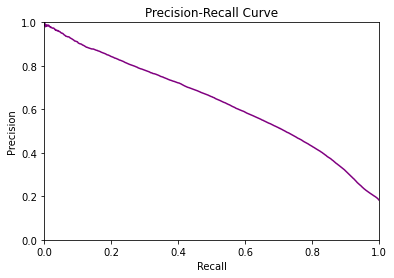

0.6348433555241657


In [15]:
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_trues_peaks, y_preds_peaks)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_xlim(0,1.0)
ax.set_ylim(0,1.0)

#display plot
plt.savefig("PR_curve_FULL_iteration84_enformer_initialized_homegrown.pdf", format="pdf", bbox_inches="tight")
plt.show()

auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

In [22]:
tf.reduce_sum(y_trues_peaks) / y_trues_peaks.shape[0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.1827419>

In [ ]:
FULL: 0.649



In [ ]:
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_trues_peaks, y_preds_peaks)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

In [ ]:
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_trues_peaks, y_preds_peaks)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

Text(0.5, 1.0, 'overall ATAC bin level correlation')

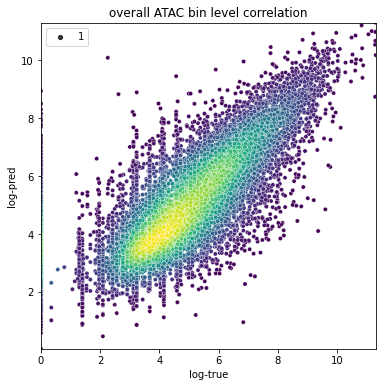

In [16]:
y_trues_atac = metric_dict['corr_stats_atac'].result()['y_trues'].numpy()
y_preds_atac = metric_dict['corr_stats_atac'].result()['y_preds'].numpy()

y_trues_atac = np.log2(1.0+y_trues_atac)
y_preds_atac = np.log2(1.0+y_preds_atac)

idx = np.random.choice(np.arange(len(y_trues_atac)), 15000, replace=False)

data = np.vstack([y_trues_atac[idx],
                  y_preds_atac[idx]])

min_true = min(y_trues_atac[idx])
max_true = max(y_trues_atac[idx])

min_pred = min(y_preds_atac[idx])
max_pred = max(y_preds_atac[idx])

fig_overall,ax_overall=plt.subplots(figsize=(6,6))
kernel = stats.gaussian_kde(data)(data)
sns.scatterplot(
    x=y_trues_atac[idx],
    y=y_preds_atac[idx],
    c=kernel,
    size=1,
    cmap="viridis")
ax_overall.set_xlim(min_true,max_true)
ax_overall.set_ylim(min_pred,max_pred)
plt.xlabel("log-true")
plt.ylabel("log-pred")
plt.title("overall ATAC bin level correlation")
#plt.savefig("SCATTER_FULL_iteration84_enformer_initialized_homegrown.pdf", format="pdf", bbox_inches="tight")

In [17]:
np.corrcoef(y_trues_atac,y_preds_atac)

array([[1.        , 0.69117585],
       [0.69117585, 1.        ]])

In [18]:
from scipy.stats.stats import pearsonr   
y_trues_atac = metric_dict['corr_stats_atac'].result()['y_trues'].numpy()
y_preds_atac = metric_dict['corr_stats_atac'].result()['y_preds'].numpy()

y_trues_atac = (y_trues_atac)
y_preds_atac = (y_preds_atac)


print(pearsonr(y_trues_atac,y_preds_atac))

(0.8174560364114664, 0.0)


In [ ]:

with strategy.scope():
    def one_hot(sequence):
        '''
        convert input string tensor to one hot encoded
        will replace all N character with 0 0 0 0
        '''
        vocabulary = tf.constant(['A', 'C', 'G', 'T'])
        mapping = tf.constant([0, 1, 2, 3])

        init = tf.lookup.KeyValueTensorInitializer(keys=vocabulary,
                                                   values=mapping)
        table = tf.lookup.StaticHashTable(init, default_value=0)

        input_characters = tfs.upper(tfs.unicode_split(sequence, 'UTF-8'))

        out = tf.one_hot(table.lookup(input_characters), 
                          depth = 4, 
                          dtype=tf.float32)
        return out

    
list_files = tf.io.gfile.glob("gs://picard-testing-176520/genformer_atac_pretrain/262k/genformer_atac_pretrain_globalacc_conv_rpgc_test_holdout/test/*.tfr")

files_list = []
for list_file in list_files:
    files = tf.data.Dataset.list_files(list_file)

    g = tf.random.Generator.from_seed(42)
    h = tf.random.Generator.from_seed(43)

    with strategy.scope():

            def deserialize_val(serialized_example,
                               input_length,
                               max_shift,
                               output_length_ATAC,
                               output_length,
                               crop_size,
                               output_res,
                               #seq_mask_dropout,
                               atac_mask_dropout,
                               mask_size,
                               log_atac,
                               use_atac,
                               use_seq,
                                g,h):
                """Deserialize bytes stored in TFRecordFile."""
                ## parse out feature map
                feature_map = {
                    'sequence': tf.io.FixedLenFeature([], tf.string),
                    'atac': tf.io.FixedLenFeature([], tf.string),
                    'tss_tokens': tf.io.FixedLenFeature([], tf.string),
                    'peaks': tf.io.FixedLenFeature([], tf.string)
                }
                ### stochastic sequence shift and gaussian noise

                seq_shift=5
                stupid_random_seed = g.uniform([], 0, 10000000,dtype=tf.int32)
                stupid_random_seed2 = h.uniform([], 0, 10000000,dtype=tf.int32)
                input_seq_length = input_length + max_shift

                ## now parse out the actual data
                data = tf.io.parse_example(serialized_example, feature_map)
                sequence = one_hot(tf.strings.substr(data['sequence'],
                                             seq_shift,input_length))
                atac = tf.ensure_shape(tf.io.parse_tensor(data['atac'],
                                                          out_type=tf.float32),
                                       [output_length_ATAC,1])
                peaks = tf.ensure_shape(tf.io.parse_tensor(data['peaks'],
                                                          out_type=tf.int32),
                                       [output_length])
                peaks = tf.expand_dims(peaks,axis=1)
                peaks_crop = tf.slice(peaks,
                                 [crop_size,0],
                                 [output_length-2*crop_size,-1])


                center = (output_length-2*crop_size)//2
                ### here set up masking of one of the peaks
                mask_indices_temp = tf.where(peaks_crop[:,0] > 0)[:,0]
                ridx = tf.concat([tf.random.experimental.stateless_shuffle(mask_indices_temp,seed=[11,stupid_random_seed+1]),
                                  tf.constant([center],dtype=tf.int64)],axis=0)   ### concatenate the middle in case theres no peaks
                mask_indices=[[ridx[0]-4+crop_size],[ridx[0]-3+crop_size],[ridx[0]-2+crop_size],
                              [ridx[0]-1+crop_size],[ridx[0]+crop_size],[ridx[0]+1+crop_size],
                              [ridx[0]+2+crop_size],[ridx[0]+3+crop_size]]

                st=tf.SparseTensor(
                    indices=mask_indices,
                    values=[1.0]*len(mask_indices),
                    dense_shape=[output_length])
                dense_peak_mask=tf.sparse.to_dense(st)
                dense_peak_mask_store = dense_peak_mask
                dense_peak_mask=1.0-dense_peak_mask
                dense_peak_mask = tf.expand_dims(dense_peak_mask,axis=1)

                atac_target = atac ## store the target

                ### here set up the ATAC masking
                num_mask_bins = mask_size // output_res
                out_length_cropped = output_length-2*crop_size
                edge_append = tf.ones((crop_size,1),dtype=tf.float32)
                atac_mask = tf.ones(out_length_cropped // num_mask_bins,dtype=tf.float32)
                atac_mask=tf.nn.experimental.stateless_dropout(atac_mask,
                                                          rate=(atac_mask_dropout),
                                                          seed=[stupid_random_seed+16,stupid_random_seed+10]) / (1. / (1.0-(atac_mask_dropout))) 
                atac_mask = tf.expand_dims(atac_mask,axis=1)
                atac_mask = tf.tile(atac_mask, [1,num_mask_bins])
                atac_mask = tf.reshape(atac_mask, [-1])
                atac_mask = tf.expand_dims(atac_mask,axis=1)
                atac_mask_store = 1.0 - atac_mask
                full_atac_mask = tf.concat([edge_append,atac_mask,edge_append],axis=0)
                full_comb_mask = tf.math.floor((dense_peak_mask + full_atac_mask)/2)
                full_comb_mask_store = 1.0 - full_comb_mask
                full_comb_mask_store = full_comb_mask_store[crop_size:-crop_size,:]
                tiling_req = output_length_ATAC // output_length
                full_comb_mask = tf.expand_dims(tf.reshape(tf.tile(full_comb_mask, [1,tiling_req]),[-1]),axis=1)
                masked_atac = atac * full_comb_mask

                ### now that we have masked specific tokens by setting them to 0, we want to randomly add wrong tokens to these positions
                ## first, invert the mask
                random_shuffled_tokens= tf.random.experimental.stateless_shuffle(atac,seed=[10,stupid_random_seed+10])
                masked_atac = masked_atac + (1.0-full_comb_mask)*random_shuffled_tokens

                if log_atac: 
                    masked_atac = tf.math.log1p(masked_atac)

                diff = tf.math.sqrt(tf.nn.relu(masked_atac - 100.0 * tf.ones(masked_atac.shape)))
                masked_atac = tf.clip_by_value(masked_atac, clip_value_min=0.0, clip_value_max=100.0) + diff

                atac_out = tf.reduce_sum(tf.reshape(atac_target, [-1,tiling_req]),axis=1,keepdims=True)
                diff = tf.math.sqrt(tf.nn.relu(atac_out - 2500.0 * tf.ones(atac_out.shape)))
                atac_out = tf.clip_by_value(atac_out, clip_value_min=0.0, clip_value_max=2500.0) + diff
                atac_out = tf.slice(atac_out,
                                    [crop_size,0],
                                    [output_length-2*crop_size,-1])

                peaks_gathered = tf.reduce_max(tf.reshape(peaks_crop, [(output_length-2*crop_size) // 2, -1]),
                                               axis=1,keepdims=True)
                mask_gathered = tf.reduce_max(tf.reshape(full_comb_mask_store, [(output_length-2*crop_size) // 2, -1]),
                                               axis=1,keepdims=True)

                random_shuffled_tokens= tf.random.experimental.stateless_shuffle(atac,
                                                                                 seed=[11,stupid_random_seed+11])
                if not use_atac:
                    masked_atac = random_shuffled_tokens
                if not use_seq:
                    sequence = tf.random.experimental.stateless_shuffle(sequence,
                                                                        seed=[12,stupid_random_seed+12])


                mask_seed = tf.cast(full_comb_mask_store,dtype=tf.int32)*stupid_random_seed + stupid_random_seed2
                masked_gathered_seed = tf.cast(mask_gathered,dtype=tf.int32)*stupid_random_seed + stupid_random_seed2

                return {'sequence': tf.ensure_shape(sequence,
                                                    [input_length,4]),
                        'atac': tf.ensure_shape(masked_atac,
                                                [output_length_ATAC,1]),
                        'mask': tf.ensure_shape(full_comb_mask_store,
                                                [output_length-crop_size*2,1]),
                        'mask_seed': tf.ensure_shape(mask_seed,
                                                [output_length-crop_size*2,1]),
                        'mask_gathered': tf.ensure_shape(mask_gathered,
                                                [(output_length-crop_size*2)//2,1]),
                        'mask_gathered_seed': tf.ensure_shape(masked_gathered_seed,
                                                [(output_length-crop_size*2)//2,1]),
                        'peaks': tf.ensure_shape(peaks_gathered,
                                                  [(output_length-2*crop_size) // 2,1]),
                        'target': tf.ensure_shape(atac_out,
                                                  [output_length-crop_size*2,1])}


            files = tf.data.Dataset.list_files(list_file)

            dataset = tf.data.TFRecordDataset(files,
                                              compression_type='ZLIB',
                                              num_parallel_reads=4)
            dataset = dataset.with_options(options)
            dataset = dataset.map(lambda record: deserialize_val(record,
                                                                262144,
                                                                10,
                                                                65536,
                                                                2048,
                                                                256,
                                                                128,
                                                                 #seq_mask_dropout,
                                                                0.10,
                                                                1024,
                                                                True,
                                                               False,
                                                               True,
                                                                g,h),
                          deterministic=False,
                          num_parallel_calls=4)

            dataset = dataset.batch(64,drop_remainder=True).prefetch(tf.data.AUTOTUNE).repeat()

            test_dist = strategy.experimental_distribute_dataset(dataset)

            test_it = iter(test_dist)
            test_it_build = iter(test_dist)
            files_list.append(test_it)

In [19]:
for i,k in enumerate(model.trainable_variables):
    print(k.name)

aformer/conv1d_42/kernel:0
aformer/conv1d_42/bias:0
sync_batch_norm_fp32/sync_batch_normalization_38/gamma:0
sync_batch_norm_fp32/sync_batch_normalization_38/beta:0
conv1d_43/kernel:0
conv1d_43/bias:0
aformer/conv1d_44/kernel:0
aformer/conv1d_44/bias:0
sync_batch_norm_fp32/sync_batch_normalization_39/gamma:0
sync_batch_norm_fp32/sync_batch_normalization_39/beta:0
conv1d_45/kernel:0
conv1d_45/bias:0
aformer/stem_pool_atac/dense_1/kernel:0
aformer/stem_pool/dense/kernel:0
aformer/embedding_2/embeddings:0
sync_batch_norm_fp32/sync_batch_normalization_40/gamma:0
sync_batch_norm_fp32/sync_batch_normalization_40/beta:0
conv1d_46/kernel:0
conv1d_46/bias:0
sync_batch_norm_fp32/sync_batch_normalization_41/gamma:0
sync_batch_norm_fp32/sync_batch_normalization_41/beta:0
conv1d_47/kernel:0
conv1d_47/bias:0
SoftmaxPooling1D/dense/kernel:0
sync_batch_norm_fp32/sync_batch_normalization_42/gamma:0
sync_batch_norm_fp32/sync_batch_normalization_42/beta:0
conv1d_48/kernel:0
conv1d_48/bias:0
sync_batch_no

TPUDistributedVariable:{
  0: <tf.Variable 'aformer/embedding_1/embeddings:0' shape=(2048, 1600) dtype=float32, numpy=
array([[ 0.0164609 ,  0.02749372, -0.01542488, ...,  0.08125965,
        -0.10188409,  0.08790673],
       [ 0.03011785,  0.0357183 ,  0.0394407 , ..., -0.0041007 ,
        -0.05729758,  0.05099118],
       [ 0.02117763, -0.00183437, -0.01333619, ..., -0.01716687,
        -0.09254447,  0.06225032],
       ...,
       [-0.02391185,  0.02890328,  0.04887392, ..., -0.00027385,
        -0.00844594,  0.0621284 ],
       [ 0.0331138 ,  0.01647806,  0.00799965, ...,  0.00052548,
        -0.07112795,  0.08235224],
       [ 0.01340021,  0.03641171,  0.03264887, ...,  0.07121241,
        -0.03582776, -0.04955046]], dtype=float32)>,
  1: <tf.Variable 'aformer/embedding_1/embeddings/replica_1:0' shape=(2048, 1600) dtype=float32, numpy=
array([[ 0.0164609 ,  0.02749372, -0.01542488, ...,  0.08125965,
        -0.10188409,  0.08790673],
       [ 0.03011785,  0.0357183 ,  0.0394407 , 